In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler


import mlflow

In [7]:
df = pd.read_csv(r'model_optimization/data/data.csv')

df_proc = df.drop(columns=['customerID'])
df_proc['TotalCharges'] = df_proc['TotalCharges'].replace(' ', np.nan).astype('float64')
df_proc = pd.get_dummies(df_proc, columns=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines', 
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV', 
                                           'StreamingMovies', 'Contract',   
                                           'PaperlessBilling', 'PaymentMethod', 'Churn'], drop_first=True)
df_proc.columns = [col.replace(' ', '_') for col in df_proc.columns]

for col in df_proc.columns:
    if df_proc[col].dtype == 'bool':
        df_proc[col] = df_proc[col].astype('int16')

In [13]:
for i in list(df_proc.columns):
    print(i, df_proc[i].dtype)

SeniorCitizen int64
tenure int64
MonthlyCharges float64
TotalCharges float64
gender_Male int16
Partner_Yes int16
Dependents_Yes int16
PhoneService_Yes int16
MultipleLines_No_phone_service int16
MultipleLines_Yes int16
InternetService_Fiber_optic int16
InternetService_No int16
OnlineSecurity_No_internet_service int16
OnlineSecurity_Yes int16
OnlineBackup_No_internet_service int16
OnlineBackup_Yes int16
DeviceProtection_No_internet_service int16
DeviceProtection_Yes int16
TechSupport_No_internet_service int16
TechSupport_Yes int16
StreamingTV_No_internet_service int16
StreamingTV_Yes int16
StreamingMovies_No_internet_service int16
StreamingMovies_Yes int16
Contract_One_year int16
Contract_Two_year int16
PaperlessBilling_Yes int16
PaymentMethod_Credit_card_(automatic) int16
PaymentMethod_Electronic_check int16
PaymentMethod_Mailed_check int16
Churn_Yes int16


In [30]:
df_proc.iloc[3001].values

array([  0. ,   9. ,  20.4, 181.8,   1. ,   0. ,   0. ,   1. ,   0. ,
         0. ,   0. ,   1. ,   1. ,   0. ,   1. ,   0. ,   1. ,   0. ,
         1. ,   0. ,   1. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   1. ,   0. ])

In [4]:
target = 'Churn_Yes'
features = df_proc.columns.drop(target)

df_proc[target] = df_proc[target].astype('int64')

In [24]:
df_proc['Partner_Yes'].dtype == 'bool'

True

In [5]:
def split_data(df: pd.DataFrame, target: str, test_size: float, 
               val_size: float=None, random_state:int = 0):
    """
    returns (X_train, y_train, X_val, y_val, X_test, y_test)
    """
    if not val_size:
        val_size = test_size / (1 - test_size)

    train_val, test = train_test_split(df, test_size=test_size, stratify=df[target], random_state=random_state)
    train, val = train_test_split(train_val, test_size=val_size, stratify=train_val[target], random_state=random_state)

    X_train = train[train.columns.drop(target)]
    X_val = val[val.columns.drop(target)]
    X_test = test[test.columns.drop(target)]

    y_train = train[target]
    y_val = val[target]
    y_test = test[target]

    print(f'train shape: {X_train.shape}\nval shape: {X_val.shape}\ntest shape: {X_test.shape}')
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_proc, target=target, test_size=0.15)

train shape: (4929, 30)
val shape: (1057, 30)
test shape: (1057, 30)


In [27]:
df_proc

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No_phone_service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaperlessBilling_Yes,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,Churn_Yes
0,0,1,29.85,29.85,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2,53.85,108.15,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,45,42.30,1840.75,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,1,1,1,1,0,1,...,1,0,1,1,0,1,0,0,1,0
7039,0,72,103.20,7362.90,0,1,1,1,0,1,...,1,0,1,1,0,1,1,0,0,0
7040,0,11,29.60,346.45,0,1,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
7041,1,4,74.40,306.60,1,1,0,1,0,1,...,0,0,0,0,0,1,0,0,1,1


In [13]:
X = pd.concat([X_train, X_val], ignore_index=True)
y = pd.concat([y_train, y_val], ignore_index=True)

In [17]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [1]:
df

NameError: name 'df' is not defined

In [19]:
def objective_lgbm(trial):   
    mlflow.set_experiment('churn1')
    experiment = mlflow.get_experiment_by_name('churn1')
    client = mlflow.tracking.MlflowClient()
    run = client.create_run(experiment.experiment_id)

    with mlflow.start_run(run_id=run.info.run_id):
        # hyperparams for the model
        params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'eval_metric': 'logloss',
        'n_estimators': 1000,
        'verbose': -100,
        'random_state': 17,

        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 2.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),

        'num_leaves': trial.suggest_int('num_leaves', 30, 60),
        'max_depth': trial.suggest_categorical('max_depth', [-1, 7, 9, 11]),

        'reg_alpha': trial.suggest_int('reg_alpha', 10, 30),
        'reg_lambda': trial.suggest_int('reg_lambda', 10, 30),

        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'col_sample_bytree': trial.suggest_float('col_sample_bytree', 0.4, 0.8)
        }

        mlflow.log_params(params)
        # arrays for metrics
        auc_array = np.array([])
        acc_array = np.array([])

        # doing 5 fold stratified cross validation
        skf = StratifiedKFold(n_splits=5)
        for i, (train_index, valid_index) in enumerate(skf.split(X=X, y=y)):

            # splitting data
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]

            X_valid = X.iloc[valid_index]
            y_valid = y.iloc[valid_index]
            
            # initializing, fitting and predicting on validation set
            lgbm = lgb.LGBMClassifier(**params)
            lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
            pred_valid = lgbm.predict_proba(X_valid)[:,-1]

            # calculating auc
            auc = roc_auc_score(y_valid, pred_valid)
            auc_array = np.append(auc_array, auc)
            mlflow.log_metric(f"val_auc_{i}", auc)

            # calculating accuracy
            acc = accuracy_score(y_valid, pred_valid>.5)
            acc_array = np.append(acc_array, acc)
            mlflow.log_metric(f"val_acc_{i}", acc)
        
        mlflow.log_metric('val_auc_avg', np.mean(auc_array))
        mlflow.log_metric('val_acc_avg', np.mean(acc_array))
        

        return np.mean(auc_array)
    
sampler = TPESampler(seed=17)
study = optuna.create_study(direction='maximize', sampler=sampler)

study.optimize(objective_lgbm, n_trials=10, show_progress_bar=True)


[I 2024-04-15 00:20:17,513] A new study created in memory with name: no-name-8a54b123-7702-428f-af97-401147f5c216


  0%|          | 0/10 [00:00<?, ?it/s]

2024/04/15 00:20:17 INFO mlflow.tracking.fluent: Experiment with name 'churn1' does not exist. Creating a new experiment.


[I 2024-04-15 00:20:18,963] Trial 0 finished with value: 0.8444706542811737 and parameters: {'scale_pos_weight': 1.2946650026871098, 'learning_rate': 0.05775280800447648, 'num_leaves': 35, 'max_depth': 7, 'reg_alpha': 22, 'reg_lambda': 10, 'subsample': 0.5431254417934196, 'col_sample_bytree': 0.7782732747273631}. Best is trial 0 with value: 0.8444706542811737.
[I 2024-04-15 00:20:19,821] Trial 1 finished with value: 0.8444567676899307 and parameters: {'scale_pos_weight': 1.0600446803153853, 'learning_rate': 0.087763789319159, 'num_leaves': 57, 'max_depth': 7, 'reg_alpha': 20, 'reg_lambda': 15, 'subsample': 0.5190902873207087, 'col_sample_bytree': 0.6246035621305445}. Best is trial 0 with value: 0.8444706542811737.
[I 2024-04-15 00:20:20,809] Trial 2 finished with value: 0.8443178827150938 and parameters: {'scale_pos_weight': 1.3960474360470265, 'learning_rate': 0.08098306387110096, 'num_leaves': 42, 'max_depth': 11, 'reg_alpha': 16, 'reg_lambda': 14, 'subsample': 0.7325455689242084, 'c

In [20]:
study.best_params

{'scale_pos_weight': 1.692896884116506,
 'learning_rate': 0.08065753221375366,
 'num_leaves': 40,
 'max_depth': 9,
 'reg_alpha': 19,
 'reg_lambda': 20,
 'subsample': 0.6563499317777979,
 'col_sample_bytree': 0.4424675409453355}

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.445491


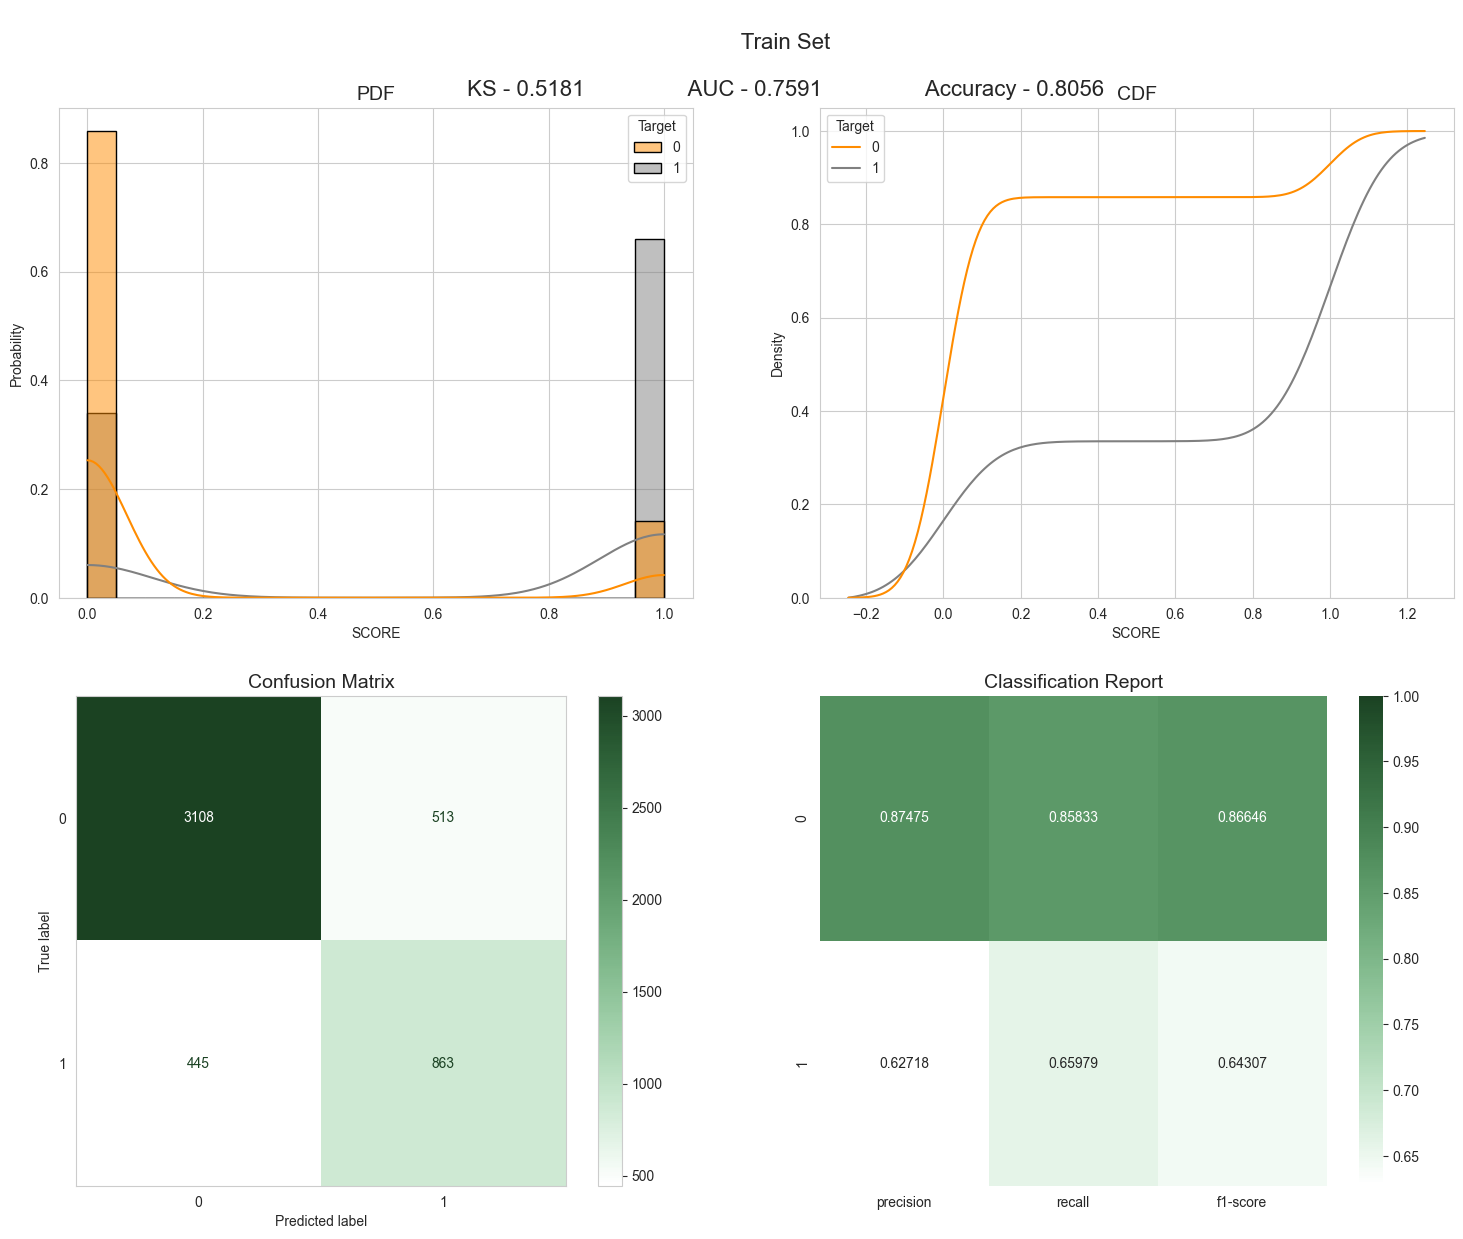

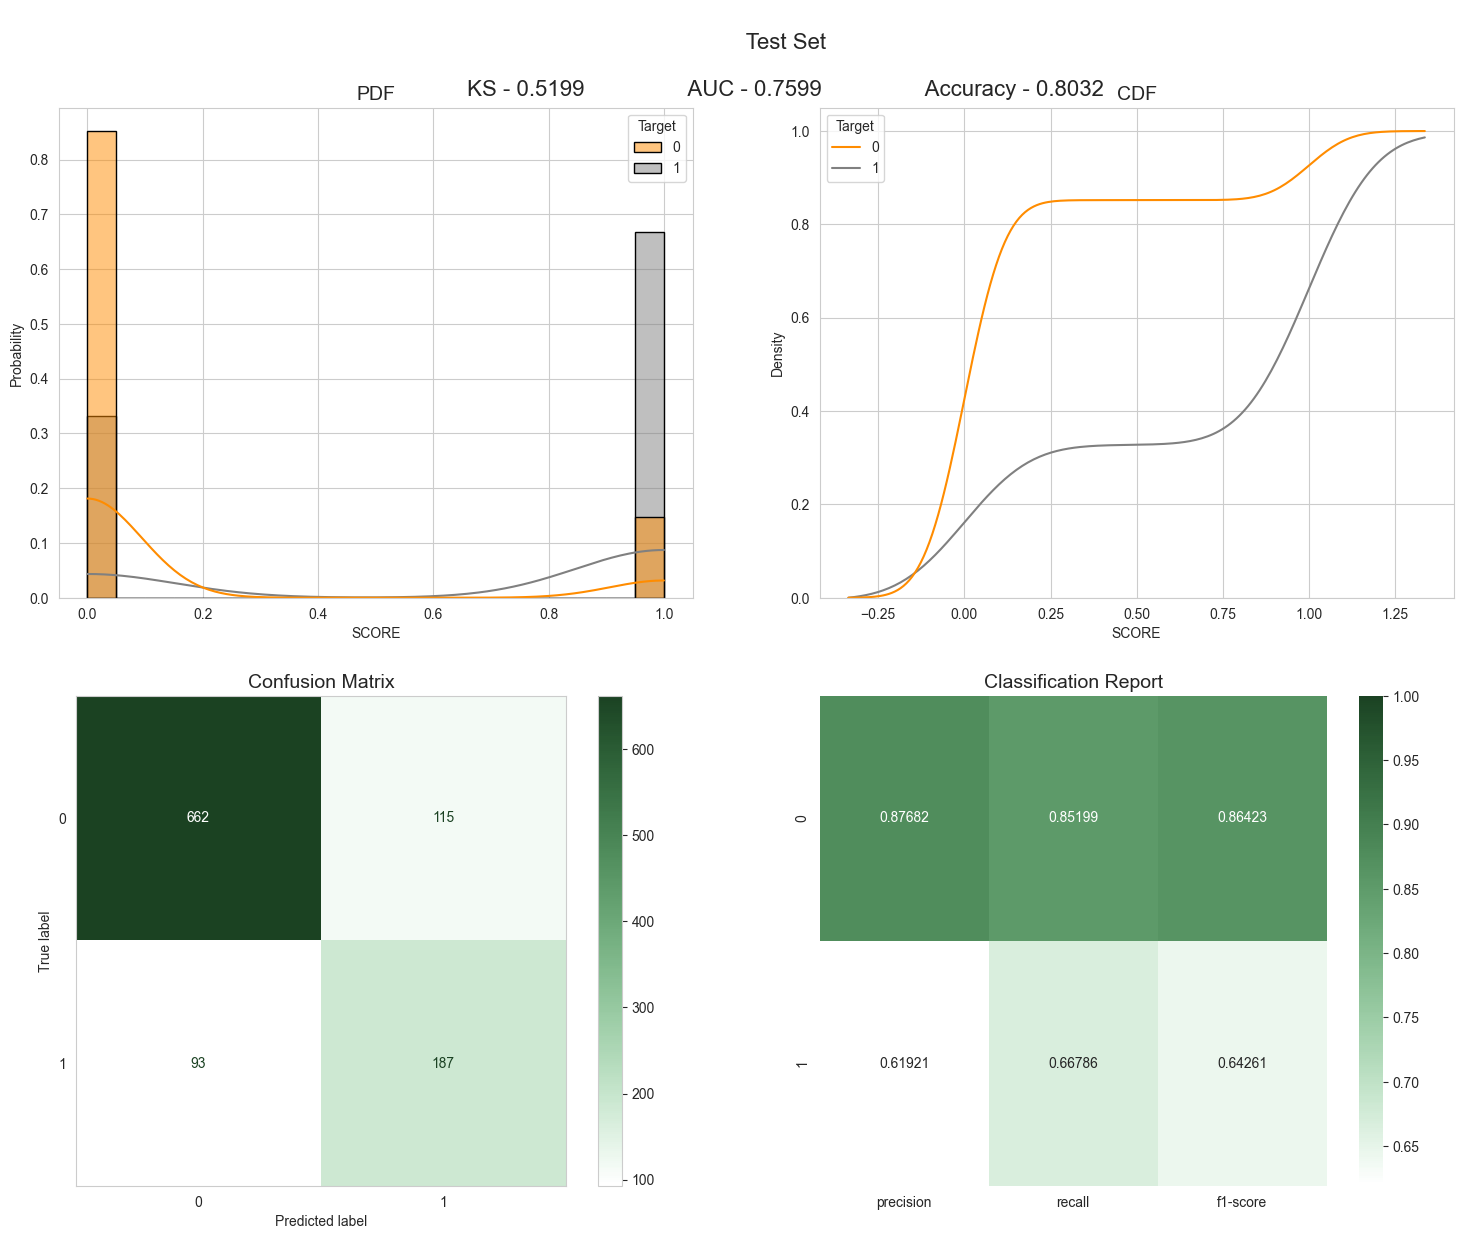

In [10]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'eval_metric': 'logloss',
    'n_estimators': 500,
    'verbose': -100,
    'random_state': 17,

    'scale_pos_weight': 1.5,
    'learning_rate': 0.03,

    'num_leaves': 30,
    'max_depth': 7,

    'reg_alpha': 30,
    'reg_lambda': 30,

    'subsample': 0.5,
    'col_sample_bytree': 0.5
}

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(10)])

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

classification_predictive_power(y_train, pred_train, set_name='Train')
classification_predictive_power(y_test, pred_test, set_name='Test')